[![Open In Colab](https://colab.research.google.com/github/ortegarcarlos/Catalysis-Mini-Notebooks/blob/main/capillary_condensation_gas_phase_reaction

# Description

Capillary condensation is the vapor-to-liquid transition that occurs inside confined pores at partial pressures below bulk saturation pressure because curved menisci lower the equilibrium vapor pressure, as described by the Kelvin equation; if unaccounted for, it will bias gas-phase catalyst tests as it changes local concentrations, blocks pore access, alters heat/mass transfer and can convert an apparent kinetic regime into a transport‑controlled one. 

This Jupyter notebook we calculate the relative pressure at which condensation in pores of radius $r_K$ becomes likely. We then calculate the critical pore radius below which capillary condensation will occur at a given relative pressure, and prepae an interactive plot for visualizing these relationships.

**Author:** Carlos Ortega
**Date:** 11/01/2026

**References:**
1. Fatemi, S., Moosavian, M. A., Abolhamd, G., Mortazavi, Y., & Hudgins, R. R. (2002). Reaction rate hysteresis in the hydrotreating of thiophene in wide‐ and narrow‐pore catalysts during temperature cycling. *The Canadian Journal of Chemical Engineering*, 80(2), 231-238. https://doi.org/10.1002/cjce.5450800208
2. Lowell, S., Shields, J. E., Thomas, M. A., & Thommes, M. (2004). *Characterization of Porous Solids and Powders: Surface Area, Pore Size and Density*. Springer Netherlands. https://doi.org/10.1007/978-1-4020-2303-3

# Import libraries and modules

In [21]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, Layout

# Input parameters

In [ ]:
# Test conditions
T = 170 + 273.15  # K, temperature
P = 9.5e5         # Pa, pressure

# Feed composition - see paper for details
yC7 = 0.427  # mole fraction of n-Heptane
yTh = 0.017  # mole fraction of Thiophene
yH2 = 0.556  # mole fraction of Hydrogen

# Universal gas constant
R = 8.314  # J/(mol·K)

# n-Heptane properties from NIST Chemistry WebBook, SRD 69
Tnb = 371.5     # K, normal boiling point
Pc = 27.4e5     # Pa, critical pressure
Tc = 540.       # K, critical temperature
Vc = 0.428e-3   # m³/mol, critical volume

# Pore radii to perform calculations - Kelvin radius [rK]
rK = np.linspace(start=0.5e-9, stop=7e-9, num=1000) # m

# Calculations

In [9]:
# Reduced temperature
Tr = T / Tc         

# n-Heptane related calculations
# ------------------------------
# Reduced normal boiling point temperature
Tnbr = Tnb / Tc
# Molar volume [Vm] - Tyn and Calus equation
Vm = 0.285 * (Vc*(1e6/1))**1.048 * (1/1e6)  # m³/mol
# Vapor pressure at test temperature (valid between 182.57 K and 540.2 K)
P0 = np.exp(87.829 - 6996.4/T - 9.8802 * np.log(T) + 7.2099E-06 * T**2) # Pa
# Partial pressure at reactor inlet conditions
pC7 = yC7 * P  # Pa
# Surface tension [sigma] - Brock and Bird (1955) equation
Q = 0.1196 * (1 + Tnbr*np.log(Pc/101325) / (1 - Tnbr)) - 0.279
sigma = (Pc*1e-5)**(2/3) * Tc**(1/3) * Q * (1 - Tr)**(11/9) * 1e-3  # N/m
# Vapor pressure over a curved surface
xC7 = 1 # mole fraction of n-Heptane in liquid phase, assumed to be pure (first condensable component)
vap_p = xC7 * P0 * np.exp((-2 * sigma * Vm) / (rK * R * T)) # Pa
# Critical statistical thickness of the adsorbed film [theta]
theta = 0.38 * (5 / np.log(P0 / vap_p))**(1/3) * (1/1e9) # m

# Critical pore radius
# --------------------
rcp = rK + theta # m

# Plot results

interactive(children=(FloatSlider(value=1.8137942375481713, description='Partial pressure (bar)', layout=Layou…

<function __main__.update_point(partial_pressure_bar)>

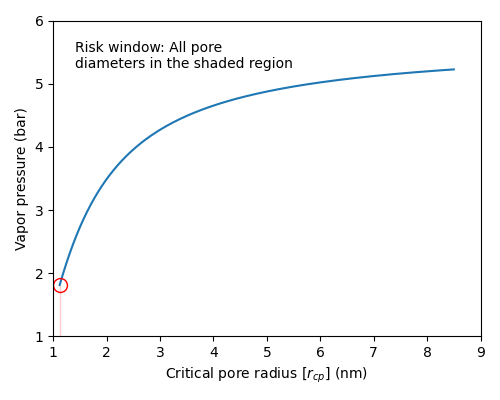

In [29]:
# Precompute the curve
rcp_nm = rcp * 1e9  # Convert to nm for plotting
vap_p_bar = vap_p / 1e5  # Convert to bar for plotting

# Create the figure and axis once
fig, ax = plt.subplots(figsize=(5, 4), tight_layout=True)

# Plot the static curve
ax.plot(rcp_nm, vap_p_bar, label='n-$C_7$ pore condensation curve')

# Create the moving point (empty red circle)
point, = ax.plot([], [], 'o', markersize=10, 
                 markerfacecolor='none', markeredgecolor='red'
                 )

# Create the shaded region (initially empty)
fill_region = ax.fill_between([], [], [], color='red', alpha=0.2)

# Configure axes
ax.set_xlim(1, 9)
ax.set_ylim(1, 6)
ax.set_xlabel('Critical pore radius [$r_{cp}$] (nm)')
ax.set_ylabel('Vapor pressure (bar)')

# Annotation
ax.annotate('Risk window: All pore\ndiameters in the shaded region', 
            xy=(0.05, 0.85), xycoords='axes fraction'
            )


def update_point(partial_pressure_bar):
    # The `global` keyword allows us to modify the fill_region variable defined outside this function
    global fill_region

    # Find nearest index in rcp array
    idx = np.abs(vap_p_bar - partial_pressure_bar).argmin()

    # Extract the corresponding values
    x = rcp_nm[idx]
    y = vap_p_bar[idx]

    # Update the point
    point.set_data([x], [y])

    # Remove previous shaded region
    fill_region.remove()

    # Build new shaded region:
    # - x from min(rcp_nm) to current x
    # - y from vap_p_bar curve up to the top of the plot
    mask = rcp_nm <= x
    fill_region = ax.fill_between(
        x = rcp_nm[mask],
        y1 = 0,
        y2 = vap_p_bar[mask],
        color='red',
        alpha=0.2
        )

    fig.canvas.draw_idle()

# Slider in nanometers
interact(
    update_point,
    partial_pressure_bar=FloatSlider(
        value=float(vap_p_bar[0]),
        min=float(vap_p_bar.min()),
        max=float(vap_p_bar.max()),
        step=0.01,
        description='Partial pressure (bar)',
        layout=Layout(width='400px'),   # adjust width here
        style={'description_width': '150px'}   # widen label area
        )
    )

In [30]:
fig.savefig('pore_condensation_curve.png', dpi=300)